In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the cambridge csv file
CUP_file_path = 'CUP_TR_2025.csv'  
CUP_df = pd.read_csv(CUP_file_path)

# Remove hyphens from ISBNs
CUP_df['ISBN'] = CUP_df['ISBN'].str.replace('-', '', regex=False)

# Load the wiley excel file
Wiley_file_path = 'Wiley textbook TR report.xlsx'  
Wiley_df = pd.read_excel(Wiley_file_path)



In [2]:
print(CUP_df.columns)

Index(['Title', 'Publisher', 'Publisher_ID', 'Platform', 'DOI',
       'Proprietary_ID', 'ISBN', 'Print_ISSN', 'Online_ISSN', 'URI',
       'Metric_Type', 'Reporting_Period_Total', 'Jan-25', 'Feb-25', 'Mar-25',
       'Apr-25', 'May-25', 'Jun-25'],
      dtype='object')


In [3]:
print(Wiley_df.columns)

Index(['Provider', 'Platform', 'Title', 'ISBN', 'Usage Date Year',
       'TR - Unique Title Requests', 'Usage Date Month'],
      dtype='object')


In [4]:
print(CUP_df['Metric_Type'].unique())

['Total_Item_Investigations' 'Unique_Item_Investigations'
 'Unique_Title_Investigations' 'Total_Item_Requests'
 'Unique_Item_Requests' 'Unique_Title_Requests' 'No_License']


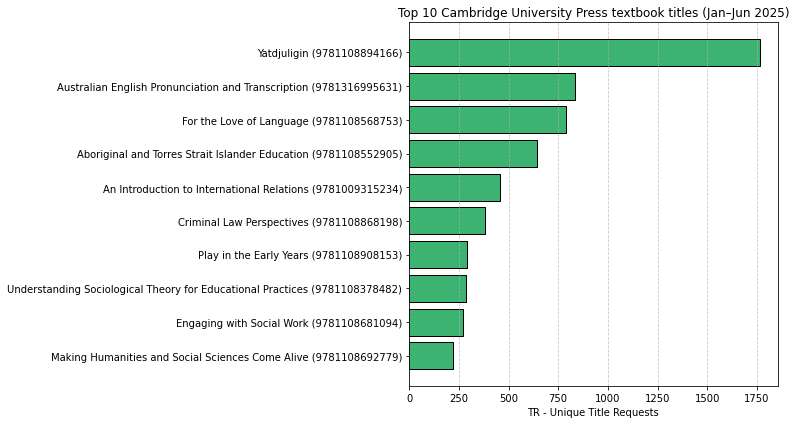

In [5]:
# Filter for Total_Item_Requests only
filtered_df = CUP_df[CUP_df['Metric_Type'] == 'Unique_Title_Requests'].copy()

# Combine Title and ISBN for labeling (handle missing ISBNs)
filtered_df['Title_Label'] = filtered_df['Title'] + ' (' + filtered_df['ISBN'].fillna('No ISBN') + ')'

# Sort by Reporting_Period_Total and get top 10
top10 = filtered_df.sort_values(by='Reporting_Period_Total', ascending=False).head(10)

# Plot
plt.figure(figsize=(11, 6))
plt.barh(top10['Title_Label'], top10['Reporting_Period_Total'], color='#3CB371', edgecolor='black')
plt.xlabel('TR - Unique Title Requests')
plt.title('Top 10 Cambridge University Press textbook titles (Jan–Jun 2025)')
plt.gca().invert_yaxis()  # Highest bar on top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('top10_CUP_requests.png', dpi=300)
plt.show()

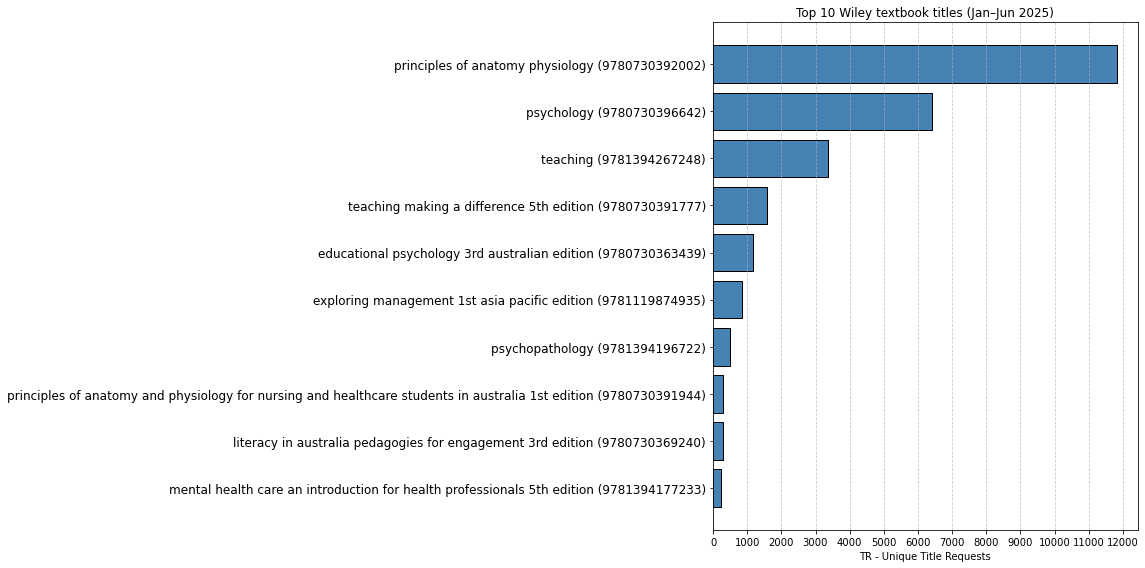

In [6]:
# Aggregate and sort as before
agg_df = Wiley_df.groupby(['Title', 'ISBN'])['TR - Unique Title Requests'].sum().reset_index()
top10 = agg_df.sort_values(by='TR - Unique Title Requests', ascending=False).head(10)
top10['label'] = top10.apply(lambda row: f"{row['Title']} ({row['ISBN']})", axis=1)

plt.figure(figsize=(16, 8))
plt.barh(top10['label'], top10['TR - Unique Title Requests'], color='#4682B4', edgecolor='black')
plt.xlabel('TR - Unique Title Requests')
plt.title('Top 10 Wiley textbook titles (Jan–Jun 2025)')
plt.gca().invert_yaxis()

# Set x-axis ticks at every 1000
max_requests = top10['TR - Unique Title Requests'].max()
plt.xticks(np.arange(0, max_requests + 1000, 1000))
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Set font size for y-axis labels
plt.yticks(fontsize=12)


plt.tight_layout()
plt.savefig('top10_wiley_requests.png', dpi=300)
plt.show()




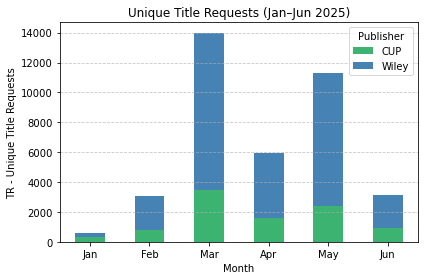

In [7]:
# 1. Filter CUP to Unique_Title_Request only
CUP_df = CUP_df[CUP_df['Metric_Type'] == 'Unique_Title_Requests'].copy()

# 2. Melt the CUP data
cup_long = CUP_df.melt(
    id_vars=['Title', 'ISBN'], 
    value_vars=['Jan-25', 'Feb-25', 'Mar-25', 'Apr-25', 'May-25', 'Jun-25'],
    var_name='Month',
    value_name='TR - Unique Title Requests'
)
cup_long['Month'] = cup_long['Month'].str[:3]  # Convert 'Jan-25' → 'Jan'
cup_long['Publisher'] = 'CUP'

# 3. Prepare Wiley data
wiley_subset = Wiley_df[['Title', 'ISBN', 'Usage Date Month', 'TR - Unique Title Requests']].copy()
wiley_subset.rename(columns={'Usage Date Month': 'Month'}, inplace=True)
wiley_subset['Month'] = wiley_subset['Month'].str[:3]  # In case month is full name
wiley_subset['Publisher'] = 'Wiley'

# 4. Combine both
combined_df = pd.concat([
    cup_long[['Month', 'TR - Unique Title Requests', 'Publisher']],
    wiley_subset[['Month', 'TR - Unique Title Requests', 'Publisher']]
])

# 5. Ensure month order is correct
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
combined_df['Month'] = pd.Categorical(combined_df['Month'], categories=month_order, ordered=True)

# 6. Group for plotting
plot_df = combined_df.groupby(['Month', 'Publisher'])['TR - Unique Title Requests'].sum().unstack().fillna(0)

# 7. Plot with custom colors
colors = {
    'CUP': '#3CB371',    # Medium Sea Green
    'Wiley': '#4682B4'   # Steel Blue
}

plot_df.plot(kind='bar', stacked=True, color=[colors[col] for col in plot_df.columns])

plt.title('Unique Title Requests (Jan–Jun 2025)')
plt.ylabel('TR - Unique Title Requests')
plt.xlabel('Month')
plt.xticks(rotation=0)
plt.legend(title='Publisher')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('stacked_column.png', dpi=300)
plt.show()

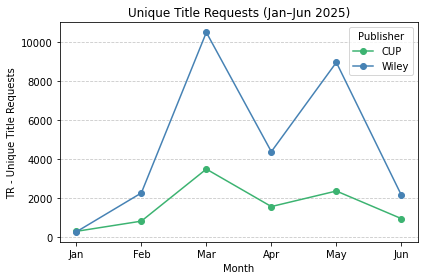

In [8]:
# Plot line graph with custom colors
colors = {
    'CUP': '#3CB371',    # Medium Sea Green
    'Wiley': '#4682B4'   # Steel Blue
}

plot_df.plot(kind='line', marker='o', color=[colors[col] for col in plot_df.columns])

plt.title('Unique Title Requests (Jan–Jun 2025)')
plt.ylabel('TR - Unique Title Requests')
plt.xlabel('Month')
plt.xticks(rotation=0)
plt.legend(title='Publisher')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('line.png', dpi=300)
plt.show()